In [ ]:
#default_exp data.transforms

The first few lines of the module defines the classes and the functionalities that needs to be imported.

```python 
__all__ =['get_files', 'FileGetter', 'image_extensions' ...] #note that this will be created automatically in fastai
``` 

When we specify from fastai.core.module import * , **python will import only functions and classes in __all__**

In [ ]:
from fastai2.torch_basics import *
from fastai2.data.core import *
from fastai2.data.load import *
from fastai2.data.external import *

In [ ]:
from nbdev.showdoc import *

In [ ]:
# class TensorCategory(TensorBase): pass

# Helper functions for processing data and basic transforms

> Functions for getting, splitting, and labeling data, as well as generic transforms

## Get, split, and label

For most data source creation we need functions to get a list of items, split them in to train/valid sets, and label them. fastai provides functions to make each of these steps easy (especially when combined with `fastai.data.blocks`).

### Get

First we'll look at functions that *get* a list of items (generally file names).

We'll use *tiny MNIST* (a subset of MNIST with just two classes, `7`s and `3`s) for our examples/tests throughout this page.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
(path/'train').ls()

(#2) [/home/quantran/.fastai/data/mnist_tiny/train/7,/home/quantran/.fastai/data/mnist_tiny/train/3]

In [ ]:
path

PosixPath('/home/quantran/.fastai/data/mnist_tiny')

In [ ]:
for i in path.ls(): print(i)

/home/quantran/.fastai/data/mnist_tiny/test
/home/quantran/.fastai/data/mnist_tiny/models
/home/quantran/.fastai/data/mnist_tiny/labels.csv
/home/quantran/.fastai/data/mnist_tiny/valid
/home/quantran/.fastai/data/mnist_tiny/train


In [ ]:
# export
# note that anything with _ in front (_get_files) is not included in __all__ => not get exported using *
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
# export
def get_files(path, extensions=None, recurse=True, folders=None):
    "Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified."
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames). os.walk is fucking fast!
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)
# this is the best get_files function there is (tested on 1.3 mil imagenet files)

This is the most general way to grab a bunch of file names from disk. If you pass `extensions` (including the `.`) then returned file names are filtered by that list. Only those files directly in `path` are included, unless you pass `recurse`, in which case all child folders are also searched recursively. `folders` is an optional list of directories to limit the search to.

In [ ]:
t3 = get_files(path/'train'/'3', extensions='.png', recurse=False)
t7 = get_files(path/'train'/'7', extensions='.png', recurse=False)
t  = get_files(path/'train', extensions='.png', recurse=True)

In [ ]:
(path/'train').ls()

(#2) [/home/quantran/.fastai/data/mnist_tiny/train/7,/home/quantran/.fastai/data/mnist_tiny/train/3]

In [ ]:
temp = get_files(path/'train', extensions='.png', recurse=False) # no recursive = not going into directory to look for files with given extensions
temp

(#0) []

In [ ]:
test_eq(len(t), len(t3)+len(t7))
test_eq(len(get_files(path/'train'/'3', extensions='.jpg', recurse=False)),0)
test_eq(len(t), len(get_files(path, extensions='.png', recurse=True, folders='train')))
t

(#709) [/home/quantran/.fastai/data/mnist_tiny/train/7/9286.png,/home/quantran/.fastai/data/mnist_tiny/train/7/7686.png,/home/quantran/.fastai/data/mnist_tiny/train/7/8137.png,/home/quantran/.fastai/data/mnist_tiny/train/7/79.png,/home/quantran/.fastai/data/mnist_tiny/train/7/8198.png,/home/quantran/.fastai/data/mnist_tiny/train/7/7663.png,/home/quantran/.fastai/data/mnist_tiny/train/7/9433.png,/home/quantran/.fastai/data/mnist_tiny/train/7/8502.png,/home/quantran/.fastai/data/mnist_tiny/train/7/9270.png,/home/quantran/.fastai/data/mnist_tiny/train/7/7380.png...]

In [ ]:
#hide
test_eq(len(get_files(path/'train'/'3', recurse=False)),346)
test_eq(len(get_files(path, extensions='.png', recurse=True, folders=['train', 'test'])),729)

It's often useful to be able to create functions with customized behavior. `fastai.data` generally uses functions named as CamelCase verbs ending in `er` to create these functions. `FileGetter` is a simple example of such a function creator.

In [ ]:
#export
def FileGetter(suf='', extensions=None, recurse=True, folders=None):
    "Create `get_files` partial function that searches path suffix `suf`, only in `folders`, if specified, and passes along args"
    def _inner(o, extensions=extensions, recurse=recurse, folders=folders):
        return get_files(o/suf, extensions, recurse, folders)
    return _inner
# function to return a function (similar to partial function)

In [ ]:
fpng = FileGetter(suf='train/7', extensions='.png', recurse=False)
test_eq(len(t7), len(fpng(path)))

In [ ]:
#same as above
fpng = FileGetter(extensions='.png', recurse=False)
test_eq(len(t7), len(fpng(path/'train'/'7')))

In [ ]:
test_eq(len(t), len(fpng(path/'train', recurse=True)))

#same as above
fpng_r = FileGetter(extensions='.png', recurse=True)
test_eq(len(t), len(fpng_r(path/'train')))

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
#export
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)

This is simply `get_files` called with a list of standard image extensions.

In [ ]:
test_eq(len(t), len(get_image_files(path, recurse=True, folders='train')))

In [ ]:
#export
def ImageGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): return get_image_files(o/suf, recurse, folders)
    return _inner

Same as `FileGetter`, but for image extensions.

In [ ]:
test_eq(len(get_files(path/'train', extensions='.png', recurse=True, folders='3')),
        len(ImageGetter(   'train',                    recurse=True, folders='3')(path)))

In [ ]:
#export
def get_text_files(path, recurse=True, folders=None):
    "Get text files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=['.txt'], recurse=recurse, folders=folders)

### Split

The next set of functions are used to *split* data into training and validation sets. The functions return two lists - a list of indices or masks for each of training and validation sets.

### random splitter

In [ ]:
# export
def RandomSplitter(valid_pct=0.2, seed=None, **kwargs):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o, **kwargs):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(int(i) for i in torch.randperm(len(o)))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
src = list(range(30))
f = RandomSplitter(seed=42)
trn,val = f(src)
assert 0<len(trn)<len(src)
assert all(o not in val for o in trn)
test_eq(len(trn), len(src)-len(val))
# test random seed consistency
test_eq(f(src)[0], trn)

### grandparent splitter

In [ ]:
# export
def _grandparent_idxs(items, name): 
    # return idx of img path that has parents == name (input parameter)
    return mask2idxs(Path(o).parent.parent.name == name for o in items)

In [ ]:
items = [path/'train/3/9932.png', path/'valid/7/7189.png', 
         path/'valid/7/7320.png', path/'train/7/9833.png',  
         path/'train/3/7666.png', path/'valid/3/925.png',
         path/'train/7/724.png', path/'valid/3/93055.png']

In [ ]:
[Path(o).parent.parent.name == 'train' for o in items]

[True, False, False, True, True, False, True, False]

In [ ]:
mask2idxs([Path(o).parent.parent.name == 'train' for o in items])

[0, 3, 4, 6]

In [ ]:
# export
def GrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _grandparent_idxs(o, train_name),_grandparent_idxs(o, valid_name)
    return _inner

In [ ]:
splitter = GrandparentSplitter()
test_eq(splitter(items),[[0,3,4,6],[1,2,5,7]])

### Index splitter

In [ ]:
#export
def IndexSplitter(valid_idx): #specific file indices for validation set
    "Split `items` so that `val_idx` are in the validation set and the others in the training set"
    def _inner(o, **kwargs):
        train_idx = np.setdiff1d(np.array(range_of(o)), np.array(valid_idx)) # find differences of 2 arrays (to be train_idx)
        return L(train_idx, use_list=True), L(valid_idx, use_list=True)
    return _inner

In [ ]:
items = list(range(10))
splitter = IndexSplitter([3,7,9])
test_eq(splitter(items),[[0,1,2,4,5,6,8],[3,7,9]])

### custom func splitter

In [ ]:
# export
def FuncSplitter(func): # func will return either true or false for EACH file (only one input at a time, no loop); true files' idxs will be val_idx
    "Split `items` by result of `func` (`True` for validation, `False` for training set)."
    def _inner(o, **kwargs):
        val_idx = mask2idxs(func(o_) for o_ in o)
        return IndexSplitter(val_idx)(o)
    return _inner

In [ ]:
fnames = [path/'train/3/9932.png', path/'valid/7/7189.png', 
          path/'valid/7/7320.png', path/'train/7/9833.png',  
          path/'train/3/7666.png', path/'valid/3/925.png',
          path/'train/7/724.png', path/'valid/3/93055.png']

In [ ]:
splitter = FuncSplitter(lambda o: Path(o).parent.parent.name == 'valid')
test_eq(splitter(fnames),[[0,3,4,6],[1,2,5,7]])

### Mask Splitter

In [ ]:
def MaskSplitter(mask): # True values in mask will go into val_idx
    "Split `items` depending on the value of `mask`."
    def _inner(o, **kwargs): return IndexSplitter(mask2idxs(mask))(o)
    return _inner

In [ ]:
items = list(range(6))
splitter = MaskSplitter([True,False,False,True,False,True])
test_eq(splitter(items),[[1,2,4],[0,3,5]])

### File splitter

In [ ]:
def FileSplitter(fname): # read a txt file and save indices of all files in that txt file as val_idx
    valid = Path(fname).read().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [ ]:
with tempfile.TemporaryDirectory() as d:
    fname = Path(d)/'valid.txt'
    fname.write('\n'.join([Path(fnames[i]).name for i in [1,3,4]]))
    splitter = FileSplitter(fname)
    test_eq(splitter(fnames),[[0,2,5,6,7],[1,3,4]])

In [ ]:
fname

PosixPath('/tmp/tmp0wbs1_h9/valid.txt')

In [ ]:
'\n'.join([Path(fnames[i]).name for i in [1,3,4]])

'7189.png\n9833.png\n7666.png'

### Col splitter

In [ ]:
# export
def ColSplitter(col='is_valid'): # there is a boolean 'valid' column in dataframe to signal which row will be in val
    "Split `items` (supposed to be a dataframe) by value in `col`"
    def _inner(o, **kwargs):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        valid_idx = o[col].values
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [ ]:
df = pd.DataFrame({'a': [0,1,2,3,4], 'b': [True,False,True,True,False]})
splits = ColSplitter('b')(df)
test_eq(splits, [[1,4], [0,2,3]])

### Label

The final set of functions is used to *label* a single item of data.

In [ ]:
# export
def parent_label(o, **kwargs): # no need for capital letter function since there's no need for customization through input parameters
    "Label `item` with the parent folder name."
    return Path(o).parent.name

Note that `parent_label` doesn't have anything customize, so it doesn't return a function - you can just use it directly.

In [ ]:
fnames

[PosixPath('/home/quantran/.fastai/data/mnist_tiny/train/3/9932.png'),
 PosixPath('/home/quantran/.fastai/data/mnist_tiny/valid/7/7189.png'),
 PosixPath('/home/quantran/.fastai/data/mnist_tiny/valid/7/7320.png'),
 PosixPath('/home/quantran/.fastai/data/mnist_tiny/train/7/9833.png'),
 PosixPath('/home/quantran/.fastai/data/mnist_tiny/train/3/7666.png'),
 PosixPath('/home/quantran/.fastai/data/mnist_tiny/valid/3/925.png'),
 PosixPath('/home/quantran/.fastai/data/mnist_tiny/train/7/724.png'),
 PosixPath('/home/quantran/.fastai/data/mnist_tiny/valid/3/93055.png')]

In [ ]:
test_eq(parent_label(fnames[0]), '3')
test_eq(parent_label("whatever/the/hell/3/666.png"), '3')
[parent_label(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
# export
class RegexLabeller():
    "Label `item` with regex `pat`."
    def __init__(self, pat): self.pat = re.compile(pat)
        
    def __call__(self, o, **kwargs):
        res = self.pat.search(str(o))
        assert res,f'Failed to find "{self.pat}" in "{o}"'
        return res.group(1)

`RegexLabeller` is a very flexible function since it handles any regex search of the stringified item. For instance, here's an example the replicates the previous `parent_label` results.

In [ ]:
f = RegexLabeller(r'/(\d)/')
[f(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

In [ ]:
regexp = re.compile(f'{re.escape(os.path.sep)}(\d){re.escape(os.path.sep)}')
f = RegexLabeller(regexp)
test_eq(parent_label(fnames[0]), '3')
[f(o) for o in fnames]

['3', '7', '7', '7', '3', '3', '7', '3']

### ColReader

In [ ]:
class ColReader(): # TODO: wtf is this
    "Read `cols` in `row` with potential `pref` and `suff`"
    def __init__(self, cols, pref='', suff='', label_delim=None):
        store_attr(self, 'suff,label_delim')
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref
        self.cols = L(cols)
    
    def _do_one(self, r, c):
        o = r[c] if isinstance(c, int) else getattr(r, c)
        if len(self.pref)==0 and len(self.suff)==0 and self.label_delim is None: return o
        if self.label_delim is None: return f'{self.pref}{o}{self.suff}'
        else: return o.split(self.label_delim) if len(o)>0 else []
    
    def __call__(self, o, **kwargs): return detuplify(tuple(self._do_one(o, c) for c in self.cols))

cols can be a list of column names or a list of indices (or a mix of both). If label_delim is passed, the result is split using it.

In [ ]:
df = pd.DataFrame({'a': 'a b c d'.split(), 'b': ['1 2', '0', '', '1 2 3']})

In [ ]:
df

,a,b
0,a,1 2
1,b,0
2,c,
3,d,1 2 3


In [ ]:
[o for o in df.itertuples()] # loop each row

[Pandas(Index=0, a='a', b='1 2'),
 Pandas(Index=1, a='b', b='0'),
 Pandas(Index=2, a='c', b=''),
 Pandas(Index=3, a='d', b='1 2 3')]

In [ ]:
# extract values of column b into arrays
f = ColReader('b')
[f(o) for o in df.itertuples()]

['1 2', '0', '', '1 2 3']

In [ ]:
# extract column b into arrays, split into subarrays using white space
f = ColReader('b', label_delim=' ')
[f(o) for o in df.itertuples()]

[['1', '2'], ['0'], [], ['1', '2', '3']]

In [ ]:
f = ColReader(['a','b'])
[f(o) for o in df.itertuples()]

[('a', '1 2'), ('b', '0'), ('c', ''), ('d', '1 2 3')]

In [ ]:
# wtf is this
f = ColReader('a', pref='0', suff='1')
test_eq([f(o) for o in df.itertuples()], '0a1 0b1 0c1 0d1'.split())

In [ ]:
df = pd.DataFrame({'a': [L(0,1), L(2,3,4), L(5,6,7)]})
df

,a
0,"[0, 1]"
1,"[2, 3, 4]"
2,"[5, 6, 7]"


In [ ]:
f = ColReader('a')
[f(o) for o in df.itertuples()]

[(#2) [0,1], (#3) [2,3,4], (#3) [5,6,7]]

## Categorize

In [ ]:
#export
class CategoryMap(CollBase):
    "Collection of categories with the reverse mapping in `o2i`"
    def __init__(self, col, sort=True, add_na=False):
        if is_categorical_dtype(col): items = L(col.cat.categories, use_list=True)
        else:
            if not hasattr(col,'unique'): col = L(col, use_list=True)
            # `o==o` is the generalized definition of non-NaN used by Pandas
            items = L(o for o in col.unique() if o==o)
            if sort: items = items.sorted()
        self.items = '#na#' + items if add_na else items # add NaN category/label, e.g. for categorical feature in tabular
        self.o2i = defaultdict(int, self.items.val2idx()) if add_na else dict(self.items.val2idx())
    def __eq__(self,b): return all_equal(b,self)

In [ ]:
t = CategoryMap([4,2,3,4])
test_eq(t, [2,3,4])
test_eq(t.o2i, {2:0,3:1,4:2})
test_fail(lambda: t.o2i['unseen label'])

In [ ]:
t

(#3) [2,3,4]

In [ ]:
t = L([4,2,3])
t.val2idx() # <L-instance>.val2idx(), make sure t contains unique values

{4: 0, 2: 1, 3: 2}

In [ ]:
t == t.items

True

In [ ]:
t = CategoryMap([4,2,3,4], add_na=True)
print(t)
test_eq(t, ['#na#',2,3,4])
test_eq(t.o2i, {'#na#':0,2:1,3:2,4:3})
print(t.o2i)

(#4) [#na#,2,3,4]
defaultdict(<class 'int'>, {'#na#': 0, 2: 1, 3: 2, 4: 3})


In [ ]:
t = CategoryMap(pd.Series([4,2,3,4]), sort=False)
test_eq(t, [4,2,3])
test_eq(t.o2i, {4:0,2:1,3:2})

In [ ]:
col = pd.Series(pd.Categorical(['M','H','L','M'], categories=['H','M','L'], ordered=True))
t = CategoryMap(col)
test_eq(t, ['H','M','L'])
test_eq(t.o2i, {'H':0,'M':1,'L':2})

In [ ]:
t=L([1],[2,3])
t

(#2) [[1],[2, 3]]

In [ ]:
sum(t,[]),type(sum(t,[])) #wtf

([1, 2, 3], list)

In [ ]:
#different from sum(t,[]). Also not convert to list
t+[]

(#2) [[1],[2, 3]]

In [ ]:
# export
class Category(str, ShowTitle): _show_args = {'label': 'category'} #string base class

In [ ]:
# export
class Categorize(Transform):
    "Reversible transform of category string to `vocab` id"
    loss_func,order=CrossEntropyLossFlat(),1
    def __init__(self, vocab=None, add_na=False):
        self.add_na = add_na
        self.vocab = None if vocab is None else CategoryMap(vocab, add_na=add_na)

    def setups(self, dsrc):
        if self.vocab is None and dsrc is not None: 
            self.vocab = CategoryMap(dsrc, add_na=self.add_na)
            
        self.c = len(self.vocab)

    def encodes(self, o): 
        return TensorCategory(self.vocab.o2i[o]) 
        #vocab is CategoryMap, containing sorted labels (categories) and label2index (o2i)
        # return type is TensorCategory, a TensorBase (TODO: why?)
        
    def decodes(self, o): return Category(self.vocab[o])


In [ ]:
??TensorCategory

In [ ]:
cat = Categorize()
# This will call 'setups' function in Categorize. Then we don't really use DataSource for the rest of this code
tds = DataSource(['cat', 'dog', 'cat'], tfms=[cat]) # tfms = [Categorize()]. 
test_eq(cat.vocab, ['cat', 'dog'])
test_eq(cat('cat'), 0) # encode
test_eq(cat.decode(1), 'dog')
test_stdout(lambda: show_at(tds,2), 'cat')

In [ ]:
cat('cat')

tensor(0)

In [ ]:
type(cat('cat'))

fastai2.torch_core.TensorCategory

In [ ]:
cat = Categorize(add_na=True)
tds = DataSource(['cat', 'dog', 'cat'], tfms=[cat])
test_eq(cat.vocab, ['#na#', 'cat', 'dog'])
test_eq(cat('cat'), 1)
test_eq(cat('#na#'), 0)
test_eq(cat.decode(2), 'dog')
test_eq(cat.decode(0), '#na#')
test_stdout(lambda: show_at(tds,2), 'cat')

## Multicategorize

In [ ]:
#export
class MultiCategory(L):
    def show(self, ctx=None, sep=';', color='black', **kwargs):
        return show_title(sep.join(self.map(str)), ctx=ctx, color=color, **kwargs)

In [ ]:
# export

class MultiCategorize(Categorize):
    "Reversible transform of multi-category strings to `vocab` id"
    loss_func,order=BCEWithLogitsLossFlat(),1
    def __init__(self, vocab=None, add_na=False):
        self.add_na = add_na
        self.vocab = None if vocab is None else CategoryMap(vocab, add_na=add_na)
        
    def setups(self, dsrc):
        if not dsrc: return
        if self.vocab is None:
            vals = set()
            for b in dsrc: vals = vals.union(set(b)) # turn the mess into 1 set
            self.vocab = CategoryMap(list(vals), add_na=self.add_na)

    def encodes(self, o): return TensorMultiCategory([self.vocab.o2i[o_] for o_ in o]) # this is TensorCategory based, which is TensorBase
    def decodes(self, o): return MultiCategory      ([self.vocab    [o_] for o_ in o])

In [ ]:
??TensorMultiCategory

In [ ]:
cat = MultiCategorize()
# This will call 'setups' function. Then we don't really use DataSource for the rest of this code
tds = DataSource([['b', 'c'], ['a'], ['a', 'c']], tfms=[cat])

test_eq(cat.vocab, ['a', 'b', 'c'])
test_eq(cat(['a', 'c']), tensor([0,2]))
test_eq(cat([]), tensor([]))
test_eq(cat.decode([1]), ['b'])
test_eq(cat.decode([0,2]), ['a', 'c'])
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
def one_hot1(x, c):
    "One-hot encode `x` with `c` classes."
    res = torch.zeros(c, dtype=torch.bool)
    res[L(x, use_list=None)] = 1.
    return res

In [ ]:
one_hot1(1,c=3)

tensor([False,  True, False])

In [ ]:
one_hot1(0,c=3)

tensor([ True, False, False])

In [ ]:
one_hot1([0,2],c=3)

tensor([ True, False,  True])

In [ ]:
# export
class OneHotEncode(Transform):
    "One-hot encodes targets"
    order=2
    def __init__(self, c=None): self.c = c

    def setups(self, dsrc):
        if self.c is None: self.c = len(L(getattr(dsrc, 'vocab', None)))
        if not self.c: warn("Couldn't infer the number of classes, please pass a value for `c` at init")

    def encodes(self, o): return TensorMultiCategory(one_hot(o, self.c).float()) # onehot data, then convert boolean to TensorMultiCategory as output
    def decodes(self, o): return one_hot_decode(o, None)
    
# class OneHotEncode(Transform):
#     "One-hot encodes targets and optionally decodes with `vocab`"
#     order=2
#     def __init__(self, do_encode=True, vocab=None): self.do_encode,self.vocab = do_encode,vocab

#     def setups(self, dsrc):
#         if self.vocab is not None:  self.c = len(self.vocab)
#         else: self.c = len(L(getattr(dsrc, 'vocab', None)))
#         if not self.c: warn("Couldn't infer the number of classes, please pass a `vocab` at init")
    
#     def encodes(self, o): return one_hot(o, self.c) if self.do_encode else tensor(o).byte() # note that this will return a tensor
#     def decodes(self, o): return one_hot_decode(o, self.vocab)
    

Works in conjunction with ` MultiCategorize` or on its own if you have one-hot encoded targets (pass a `vocab` for decoding and `do_encode=False` in this case)

In [ ]:
TensorBase??

In [ ]:
_tfm = OneHotEncode(c=3)
test_eq(_tfm([0,2]), tensor([1.,0,1.])) # has to be float tensor, not int or long like [1,0,1] since TensorBase is float
test_eq(_tfm.decode(tensor([0,1,1])), [1,2])
test_eq(_tfm.decode(tensor([False,True,True])), [1,2])

In [ ]:
_tfm([0,2]),type(_tfm([0,2]))

(tensor([1., 0., 1.]), fastai2.torch_core.TensorMultiCategory)

In [ ]:
# _tfm = OneHotEncode(vocab=['a', 'b', 'c'])
# tds = DataSource([[1,2], [0], [0, 1]], tfms=[_tfm]) 
# # you don't put str label ('a','b'...) here since this tfm should be after multicategorize, where str are numericalized (See below)
# # in that case, output of multicategorize's vocab will be used for OneHotEncode setups: self.c = len(L(getattr(dsrc, 'vocab', None)))
# test_eq(_tfm([0,2]), tensor([1, 0, 1]).byte())
# test_eq(_tfm.decode(tensor([0,1,1])), ['b','c'])

In [ ]:
# _tfm(1), _tfm([0,2]) # calling encode in OneHotEncode

In [ ]:
# tds

In [ ]:
# # do_encode = False => you have to input onehot-ed data (OneHotEncode won't one_hot for you)
# _tfm = OneHotEncode(vocab=['a', 'b', 'c'], do_encode=False)
# tds = DataSource([[0,1,1], [1,0,0], [1,1,0]], tfms=[_tfm])
# test_eq(_tfm([1,0,1]), tensor([1, 0, 1]).byte())
# test_eq(_tfm.decode(tensor([0,1,1])), ['b','c'])

### Combine MultiCategorize and OneHotEncode

In [ ]:
tds = DataSource([['b', 'c'], ['a'], ['a', 'c'], []], [[MultiCategorize(), OneHotEncode()]])
# Note that data in DataSource ALREADY numericalized by multicat and then 1hotencoded to be TensorMultiCategory
test_eq(tds[1], [tensor([1.,0,0])]) 
test_eq(tds[3], [tensor([0.,0,0])])

In [ ]:
# decoded by Onehot, then decoded by MultiCat to spit out string labels. Note that none of OneHot or MultiCat has show() func so it decodes ALL THE WAY BACK
test_eq(tds.decode([tensor([False, True, True])]), [['b','c']]) 

test_eq(type(tds[1][0]), TensorMultiCategory)
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
type(tds[1])

tuple

In [ ]:
# data in tds are already numericalized by multicat and then 1hotencoded to be TensorMultiCategory
tds

(#4) [(tensor([0., 1., 1.]),),(tensor([1., 0., 0.]),),(tensor([1., 0., 1.]),),(tensor([0., 0., 0.]),)]

In [ ]:
# you can use MultiCat even for single label dataset
tds = DataSource(['a','b','a','c'], [[MultiCategorize(), OneHotEncode()]])
print(tds)

(#4) [(tensor([1., 0., 0.]),),(tensor([0., 1., 0.]),),(tensor([1., 0., 0.]),),(tensor([0., 0., 1.]),)]


In [ ]:
test_eq(tds[1], [tensor([0,1.,0])])
test_eq(tds.decode([tensor([False, True, False])]), [['b']])
test_eq(type(tds[1][0]), TensorMultiCategory)

In [ ]:
#test with passing the vocab
tds = DataSource([['b', 'c'], ['a'], ['a', 'c'], []], [[MultiCategorize(vocab=['a', 'b', 'c']), OneHotEncode()]])
test_eq(tds[1], [tensor([1.,0,0])])
test_eq(tds[3], [tensor([0.,0,0])])
test_eq(tds.decode([tensor([False, True, True])]), [['b','c']])
test_eq(type(tds[1][0]), TensorMultiCategory)
test_stdout(lambda: show_at(tds,2), 'a;c')

In [ ]:
# export
class EncodedMultiCategorize(Categorize):
    "Transform of one-hot encoded multi-category that decodes with `vocab`"
    loss_func,order=BCEWithLogitsLossFlat(),1
    def __init__(self, vocab): self.vocab,self.c = vocab,len(vocab)
    def encodes(self, o): return TensorCategory(tensor(o).float()) # accept onehot-encoded data?
    def decodes(self, o): return MultiCategory (one_hot_decode(o, self.vocab)) # decode onehot back to string label using vocab

In [ ]:
_tfm = EncodedMultiCategorize(vocab=['a', 'b', 'c'])
test_eq(_tfm([1,0,1]), tensor([1., 0., 1.]))
test_eq(type(_tfm([1,0,1])), TensorCategory)
test_eq(_tfm.decode(tensor([True, False, True])), ['a','c'])
test_eq(_tfm.decode(tensor([1., 0, 1])), ['a','c'])

In [ ]:
#export
def get_c(dbunch): # get number of classes (labels)
    if getattr(dbunch, 'c', False): return dbunch.c
    vocab = getattr(dbunch, 'vocab', [])
    if len(vocab) > 0 and is_listy(vocab[-1]): vocab = vocab[-1]
    return len(vocab)

## End-to-end dataset example with MNIST

Let's show how to use those functions to grab the mnist dataset in a `DataSource`. First we grab all the images.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)

Then we split between train and validation depending on the folder.

In [ ]:
splitter = GrandparentSplitter() 
splits = splitter(items) # [<indices of train img>,<indices of val img>]

In [ ]:
train,valid = (items[i] for i in splits)
train[:3],valid[:3]

((#3) [/home/quantran/.fastai/data/mnist_tiny/train/7/9286.png,/home/quantran/.fastai/data/mnist_tiny/train/7/7686.png,/home/quantran/.fastai/data/mnist_tiny/train/7/8137.png],
 (#3) [/home/quantran/.fastai/data/mnist_tiny/valid/7/9851.png,/home/quantran/.fastai/data/mnist_tiny/valid/7/8510.png,/home/quantran/.fastai/data/mnist_tiny/valid/7/946.png])

Our inputs are images that we open and convert to tensors, our targets are labeled depending on the parent directory and are categories.

In [ ]:
from PIL import Image
def open_img(fn:Path): return Image.open(fn).copy() # doesn't use PILImage.create because haven't reached that part yet in this notebook
def img2tensor(im:Image.Image): return TensorImage(array(im)[None])
# note that these 2 are just functions, but when put into pipeline, they become 'Transform' (see more in live-code notebook)

tfms = [[open_img, img2tensor],
        [parent_label, Categorize()]]
train_ds = DataSource(train, tfms)

In [ ]:
train[3]

PosixPath('/home/quantran/.fastai/data/mnist_tiny/train/7/79.png')

In [ ]:
x,y = train_ds[3]
xd,yd = decode_at(train_ds,3)

In [ ]:
x.shape,xd.shape,type(x),type(xd)

(torch.Size([1, 28, 28]),
 torch.Size([1, 28, 28]),
 fastai2.torch_core.TensorImage,
 fastai2.torch_core.TensorImage)

In [ ]:
test_eq(x,xd) 
# decode does not do anything, because output of img2Tensor is TensorImage, which knows how to show(). Also img2tensor and open_img does not have 'decode' func

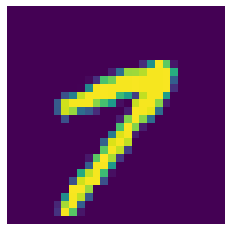

In [ ]:
x.show()

In [ ]:
y,yd,type(y),type(yd)

(tensor(1), '7', fastai2.torch_core.TensorCategory, __main__.Category)

In [ ]:
test_eq(parent_label(train[3]),yd)
test_eq(array(Image.open(train[3])),xd[0].numpy())

In [ ]:
??show_at

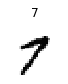

In [ ]:
ax = show_at(train_ds, 3, cmap="Greys", figsize=(1,1))

In [ ]:
assert ax.title.get_text() in ('3','7')
test_fig_exists(ax)

## ToTensor -

In [ ]:
#export
class ToTensor(Transform):
    "Convert item to appropriate tensor class"
    order = 15

## Cuda -

In [ ]:
# export
@docs
class Cuda(Transform):
    "Move batch to `device` (defaults to `default_device()`)"
    def __init__(self,device=None):
        self.device=default_device() if device is None else device
        super().__init__(split_idx=None, as_item=False)
    def encodes(self, b): return to_device(b, self.device)
    def decodes(self, b): return to_cpu(b)

    _docs=dict(encodes="Move batch to `device`", decodes="Return batch to CPU")
    
    #Note: in pipeline or batch_tfms (for after_batch) in DataSource, you can just put in 'to_device' partial function, 
    # instead of using a separate transform class like this
    # but you lose the 'decode' part. Your choice

Note that, like all `Transform`s, `encodes` is called by `tfm()` and `decodes` is called by `tfm.decode()`.

In [ ]:
Cuda()(tensor(1)) # again, Transform class can be performed on single item as well

tensor(1, device='cuda:0')

In [ ]:
tfm = Cuda()
t = tfm((tensor(1),))
print(t)
test_eq(*t,1)
test_eq(t[0].type(),'torch.cuda.LongTensor' if default_device().type=='cuda' else 'torch.LongTensor')

(tensor(1, device='cuda:0'),)


In [ ]:
t = tfm.decode(t)
test_eq(*t,1)
test_eq(t[0].type(),'torch.LongTensor')

In [ ]:
class A(Transform): 
    def encodes(self, x): return x 
    def decodes(self, x): return Int(x) 
    
start = torch.arange(0,50)
tds = DataSource(start, [A()])
tdl = TfmdDL(tds, after_batch=Cuda, bs=4)
test_eq(tdl.device, default_device())

## IntToFloatTensor, as_item and type reserve (part 1)

In [ ]:
# export
class IntToFloatTensor(Transform):
    "Transform image to float tensor, optionally dividing by 255 (e.g. for images)."
    order = 20 #Need to run after CUDA if on the GPU
    def __init__(self, div=255., div_mask=1, split_idx=None, as_item=True):
        super().__init__(split_idx=split_idx,as_item=as_item)
        self.div,self.div_mask = div,div_mask

    def encodes(self, o:TensorImage): return o.float().div_(self.div)
    def encodes(self, o:TensorMask ): return o.div_(self.div_mask).long() # convert mask to long int
    def decodes(self, o:TensorImage): return o.clamp(0., 1.) if self.div else o
    # Important: if o does not match with any type (TensorImage or TensorMask) => no encode is performed)

In [ ]:
t = TensorImage(tensor(1)) # note that similarly to all transform above, this transform can be executed on 1 single things (doesnt have to be a tuple)
tfm = IntToFloatTensor(as_item=False)
ft = tfm(t)
ft

tensor(0.0039)

In [ ]:
t = (TensorImage(tensor(1)),TensorImage(tensor(1)))
tfm = IntToFloatTensor(as_item=True) # note that if you input a Tuple type and as_item=True, the whole Tuple is treated as one single item
# and since there is no specific encode for tuple type, no transformation is performed.
ft = tfm(t)
print(ft)


t = TensorImage(tensor(1))
tfm = IntToFloatTensor(as_item=True) # with only one thing (not a tuple), and as_item=True, the type is recognized, so tfm is performed
ft = tfm(t)
print(ft)

(tensor(1), tensor(1))
tensor(0.0039)


In [ ]:
t = (TensorImage(tensor(1)),tensor(2).long(),TensorMask(tensor(3)))
tfm = IntToFloatTensor(as_item=False)
ft = tfm(t)

In [ ]:
ft # TensorImage got floated and div 255, ordinary tensor not transformed, TensorMask got div by 1 so nothing happen

(tensor(0.0039), tensor(2), tensor(3))

In [ ]:
tfm.decode(ft[0]) # TODO: isn't decode suppose to switch this back to 255 scale? Why clamp (0,1)?

tensor(0.0039)

In [ ]:
#input type vs output type. Notice that fastai type is reserved (the custom fastai type - TensorImage, not the pytorch type, due to IntToFloat tfms)
print(type(t[0]),t[0].type()) #input
print(type(ft[0]),ft[0].type()) #output

<class 'fastai2.torch_core.TensorImage'> torch.LongTensor
<class 'fastai2.torch_core.TensorImage'> torch.FloatTensor


### Reserve type for decode

In [ ]:
print(type(tfm.decode(ft[0])), tfm.decode(ft[0]).type()) #decode reserves both the pytorch type and fastai type

<class 'fastai2.torch_core.TensorImage'> torch.FloatTensor


In [ ]:
test_eq(ft, [1./255, 2, 3])
test_eq(type(ft[0]), TensorImage)
test_eq(type(ft[2]), TensorMask)
test_eq(ft[0].type(),'torch.FloatTensor')
test_eq(ft[1].type(),'torch.LongTensor')
test_eq(ft[2].type(),'torch.LongTensor')

## Normalization -

### Quick review on parameters passing in function and .view()

In [ ]:
def temp_func(a,b,*c,**d):
    print(a)
    print(b)
    print(c)
    print(d)

In [ ]:
temp_func(1,2,3,4,5,fuck="6")

1
2
(3, 4, 5)
{'fuck': '6'}


In [ ]:
tensor([1,2,3,4,5,6,7,8]).view(2,4)

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [ ]:
tensor([1,2,3,4,5,6,7,8]).view(2,-1)

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

In [ ]:
tensor([1,2,3,4,5,6,7,8]).view(4,2).view(-1) # straighten back

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
# export
def broadcast_vec(dim, ndim, *t, cuda=True):
    "Make a vector broadcastable (change to correct shape for matrix calculation) over `dim` (out of `ndim` total) for EACh value in t by prepending and appending unit axes"
    v = [1]*ndim
    v[dim] = -1
    f = to_device if cuda else noop
    return [f(tensor(o).view(*v)) for o in t]

In [ ]:
temp = [1,2,3]
temp1 = broadcast_vec(0,3,temp)[0] 
print(temp1,temp1.shape)

tensor([[[1]],

        [[2]],

        [[3]]], device='cuda:0') torch.Size([3, 1, 1])


In [ ]:
tensor(temp).view(-1,1,1) # which is just tensor(temp).view(3,1,1)

tensor([[[1]],

        [[2]],

        [[3]]])

In [ ]:
temp1 = broadcast_vec(1,4,temp)[0] # you can even add new axis
print(temp1,temp1.shape)

tensor([[[[1]],

         [[2]],

         [[3]]]], device='cuda:0') torch.Size([1, 3, 1, 1])


In [ ]:
# we need this broadcast func to turn mean (or std) vector in to broadcastable vector, in order to do this
temp1 = broadcast_vec(1,4,temp,cuda=False)[0] 
torch.zeros(2,3,2,2) - temp1 # image_batch - mean

tensor([[[[-1., -1.],
          [-1., -1.]],

         [[-2., -2.],
          [-2., -2.]],

         [[-3., -3.],
          [-3., -3.]]],


        [[[-1., -1.],
          [-1., -1.]],

         [[-2., -2.],
          [-2., -2.]],

         [[-3., -3.],
          [-3., -3.]]]])

In [ ]:
# export
@docs
class Normalize(Transform):
    "Normalize/denorm batch of `TensorImage`"
    order=99
    def __init__(self, mean=None, std=None, axes=(0,2,3)): self.mean,self.std,self.axes = mean,std,axes
    
    @classmethod
    def from_stats(cls, mean, std, dim=1, ndim=4, cuda=True): return cls(*broadcast_vec(dim, ndim, mean, std, cuda=cuda))
    
    def setups(self, dl:DataLoader): 
        if self.mean is None or self.std is None: # if no mean or std is provided, calculate meand and std from 1 batch
            x,*_ = dl.one_batch() 
            self.mean,self.std = x.mean(self.axes, keepdim=True),x.std(self.axes, keepdim=True)+1e-7

    def encodes(self, x:TensorImage): return (x-self.mean) / self.std
    def decodes(self, x:TensorImage):
        f = to_cpu if x.device.type=='cpu' else noop
        return (x*f(self.std) + f(self.mean))

    _docs=dict(encodes="Normalize batch", decodes="Denormalize batch")

In [ ]:
tfms = [[open_img, img2tensor],
        [parent_label, Categorize()]]
train_ds = DataSource(train, tfms)

In [ ]:
mean,std = [0.5]*3,[0.5]*3
mean,std = broadcast_vec(1, 4, mean, std)
batch_tfms = [Cuda(), IntToFloatTensor(), Normalize.from_stats(mean,std)]
tdl = TfmdDL(train_ds, after_batch=batch_tfms, bs=4)

In [ ]:
x,y  = tdl.one_batch()
xd,yd = tdl.after_batch.decode((x,y))

In [ ]:
test_eq(x.type(), 'torch.cuda.FloatTensor' if default_device().type=='cuda' else 'torch.FloatTensor')
test_eq(xd.type(), 'torch.FloatTensor')
test_eq(type(x), TensorImage)
test_eq(type(y), TensorCategory)
assert x.mean()<0.0
assert x.std()>0.5
assert 0<xd.mean()/255.<1
assert 0<xd.std()/255.<0.5

In [ ]:
# another example of keeping 'decode' input and output the same
print(type(train_ds[0][0]),train_ds[0][0].type()) # input x
print(type(x),x.type()) # output x

<class 'fastai2.torch_core.TensorImage'> torch.ByteTensor
<class 'fastai2.torch_core.TensorImage'> torch.cuda.FloatTensor


In [ ]:
print(type(train_ds[0][1]),train_ds[0][1].type()) # input y
print(type(y),y.type()) # output y

<class 'fastai2.torch_core.TensorCategory'> torch.LongTensor
<class 'fastai2.torch_core.TensorCategory'> torch.cuda.LongTensor


In [ ]:
print(type(xd),xd.type()) # decode output for output x
print(type(yd),yd.type()) # decode output for output y

# throughout all this, normal type (fastai type) is reserved
# but you can see pytorch type change, e.g. for x it goes from ByteTensor to cuda FloatTensor (Cuda + IntToFloat tfms) to FloatTensor
# and for y it goes from LongTensor to cuda LongTensor to LongTensor

<class 'fastai2.torch_core.TensorImage'> torch.FloatTensor
<class 'fastai2.torch_core.TensorCategory'> torch.LongTensor


In [ ]:
#Just for visuals
from fastai2.vision.core import *

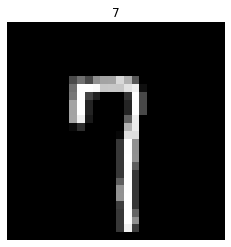

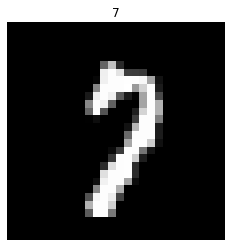

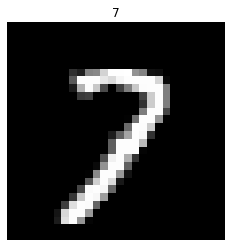

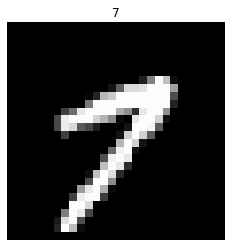

In [ ]:
tdl.show_batch((x,y))

In [ ]:
print(type(x),x.type())
print(type(y),y.type())

<class 'fastai2.torch_core.TensorImage'> torch.cuda.FloatTensor
<class 'fastai2.torch_core.TensorCategory'> torch.cuda.LongTensor


In [ ]:
x,y = torch.add(x,0),torch.add(y,0) #Lose type of tensors (to emulate predictions)
print(type(x),x.type())
print(type(y),y.type()) # normal type is changed

<class 'torch.Tensor'> torch.cuda.FloatTensor
<class 'torch.Tensor'> torch.cuda.LongTensor


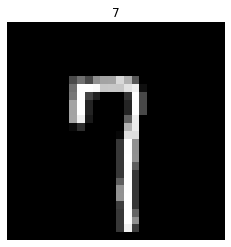

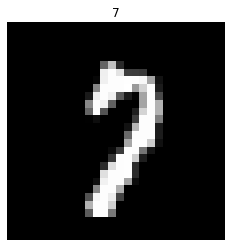

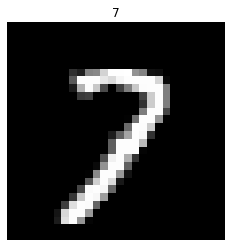

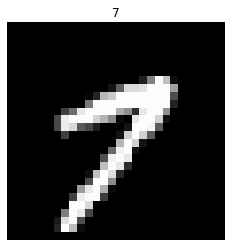

In [ ]:
test_ne(type(x), TensorImage)
tdl.show_batch((x,y), figsize=(4,4)) #x and y types are put back to their original: TensorImage and TensorCategory

## Export -